# Mục Đích
> Trong phần này chúng ta sẽ cùng đi qua các phương thức để tạo được dataset của tensorflow, bao gồm:
> 1. Load dữ liệu có sẵn của tensorflow_datasets
> 2. Load dữ liệu từ folder
> 3. Load dữ liệu từ file excel

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__, keras.__version__

('2.5.0', '2.5.0')

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## LOAD DATA ONLINE

### Sử dụng keras datasets

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

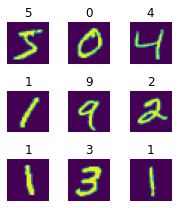

In [ ]:
# Kiểm tra dữ liệu:
fig = plt.figure(figsize=(3, 3))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i,:])
    plt.title(y_train[i])
    plt.axis('off')
    plt.tight_layout()

In [ ]:
# Biến đổi dữ liệu:
X_train = X_train/255
X_test = X_test/255

In [ ]:
# Kiểm tra dữ liệu sau khi chia cho 225 (giá trị sẽ từ 0 đến 1)
X_train[1, 10:15, 10:15]

array([[0.93333333, 0.98823529, 0.98823529, 0.70196078, 0.04705882],
       [0.99215686, 0.91372549, 0.81568627, 0.32941176, 0.        ],
       [0.94117647, 0.27843137, 0.0745098 , 0.10980392, 0.        ],
       [0.24705882, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [ ]:
# Normalize dữ liệu trước khi train, sử dụng mean và variance của imagenet:
# https://forums.fast.ai/t/is-normalizing-the-input-image-by-imagenet-mean-and-std-really-necessary/51338
normalizer = keras.layers.experimental.preprocessing.Normalization(mean=0.485, variance=0.229**2, name='normalize') 
X_train = normalizer(X_train)
X_test = normalizer(X_test)
X_train.shape, X_test.shape

(TensorShape([60000, 28, 28]), TensorShape([10000, 28, 28]))

In [ ]:
# Kiểm tra dữ liệu sau khi normalize:
X_train[1, 10:15, 10:15]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 1.9577874 ,  2.1975338 ,  2.1975338 ,  0.94742703, -1.9124069 ],
       [ 2.2146587 ,  1.8721637 ,  1.4440448 , -0.67942464, -2.117904  ],
       [ 1.9920369 , -0.9020464 , -1.7925336 , -1.6384109 , -2.117904  ],
       [-1.0390445 , -2.117904  , -2.117904  , -2.117904  , -2.117904  ],
       [-2.117904  , -2.117904  , -2.117904  , -2.117904  , -2.117904  ]],
      dtype=float32)>

#### Tạo neural net cơ bản:

In [ ]:
# Tạo neural net cơ bản:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='flatten'),
    keras.layers.Dense(128, activation='relu', name='layer1'),
    keras.layers.Dropout(.2, name='dropout'),
    keras.layers.Dense(20, activation='relu', name='layer2'),
    keras.layers.Dense(10, activation='softmax', name='predictions')
])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
predictions (Dense)          (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Đào tạo:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.7460 - accuracy: 0.7609 - val_loss: 0.2212 - val_accuracy: 0.9361
Epoch 2/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2693 - accuracy: 0.9200 - val_loss: 0.1755 - val_accuracy: 0.9486
Epoch 3/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2263 - accuracy: 0.9353 - val_loss: 0.1567 - val_accuracy: 0.9566
Epoch 4/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2015 - accuracy: 0.9426 - val_loss: 0.1647 - val_accuracy: 0.9546
Epoch 5/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1769 - accuracy: 0.9477 - val_loss: 0.1562 - val_accuracy: 0.9593


**Lưu ý:** chúng ta sử dụng thêm normalizer để normalize dữ liệu thì kết quả metrics chưa thực sự rõ ràng, tuy nhiên loss được cải thiện tương đối.

#### Thay đổi tốc độ học:
> tốc độ học (learning rate) đi kèm với optimizer trong keras, nên muốn tác động vào lr, chúng ta có thể làm bằng 1 trong 2 cách sau:

_Chọn optimizer bằng method trong keras.optimizers_

In [ ]:
# Learning rate (tốc độ học) đi kèm với optimizer. Chúng ta có thể tác động vào learning rate với keras.optimizers:
optimizer = keras.optimizers.RMSprop(learning_rate=3e-3)

_Hoặc sử dụng keras backends để sửa learning rate_

In [ ]:
# Hoặc bằng cách sử dụng backend set_value method:
print('lr before: ', model.optimizer.learning_rate.numpy())
K.set_value(model.optimizer.learning_rate, 0.003)
print('lr after: ', model.optimizer.learning_rate.numpy())

lr before:  0.001
lr after:  0.003


#### Thay đổi hàm loss:
> hàm loss (hàm mất mát) cũng có thể được thay đổi tương tự như learning rate.

In [ ]:
dir(keras.losses)

['BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'KLD',
 'KLDivergence',
 'LogCosh',
 'Loss',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'Reduction',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'cosine_similarity',
 'deserialize',
 'get',
 'hinge',
 'huber',
 'kl_divergence',
 'kld',
 'kullback_leibler_divergence',
 'log_cosh',
 'logcosh',
 'mae',
 'mape',
 'mean_absolute_error',
 'mean_absolute_percentage_error',
 'mean_squared_error',
 'mean_squared_logarithmic_error',
 'mse',
 'msle',
 'poisson',
 'serialize',
 'sparse_categorical_crossentropy',
 'squared_hinge']

In [ ]:
# tạo hàm loss:
loss_func = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_func, metrics='accuracy')

In [ ]:
# sửa hàm loss dùng backend.set_value:
# print('loss func before: ', model.loss)
# K.set_value(model.loss, keras.losses.categorical_crossentropy)
# print('loss func after: ', model.loss)

In [ ]:
# Đào tạo lại
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2)

Epoch 1/2
1875/1875 [==============================] - 26s 13ms/step - loss: 0.9586 - accuracy: 0.7291 - val_loss: 0.2956 - val_accuracy: 0.9178
Epoch 2/2
1875/1875 [==============================] - 25s 14ms/step - loss: 0.3808 - accuracy: 0.8878 - val_loss: 0.2168 - val_accuracy: 0.9347


#### Thay đổi metrics
> Tương tự như lr và loss, chúng ta cũng có thể thay đổi metrics.

In [ ]:
dir(keras.metrics)

['AUC',
 'Accuracy',
 'BinaryAccuracy',
 'BinaryCrossentropy',
 'CategoricalAccuracy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'FalseNegatives',
 'FalsePositives',
 'Hinge',
 'KLD',
 'KLDivergence',
 'LogCoshError',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'Mean',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanIoU',
 'MeanRelativeError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'MeanTensor',
 'Metric',
 'Poisson',
 'Precision',
 'PrecisionAtRecall',
 'Recall',
 'RecallAtPrecision',
 'RootMeanSquaredError',
 'SensitivityAtSpecificity',
 'SparseCategoricalAccuracy',
 'SparseCategoricalCrossentropy',
 'SparseTopKCategoricalAccuracy',
 'SpecificityAtSensitivity',
 'SquaredHinge',
 'Sum',
 'TopKCategoricalAccuracy',
 'TrueNegatives',
 'TruePositives',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_accuracy',
 'binary_crossentropy',
 'categorica

In [ ]:
# precision = keras.metrics.Precision()
# recall = keras.metrics.Recall()

In [ ]:
# Tạo hàm F1Score dự vào True Positive (TP), False Positive (FP) và False Negative (FN):
# def f1(y_true, y_pred):
#     # Tính True Positive:
#     TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     # Tính Actual Positve: TP + FN
#     TP_FN = K.sum(K.round(K.clip(y_true, 0, 1)))
#     # Tính Predicted Positve: TP + FP
#     TP_FP = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     return  (2 * TP)/(TP_FN + TP_FP + K.epsilon())

In [ ]:
model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
predictions (Dense)          (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32)

1875/1875 [==============================] - 25s 13ms/step - loss: 0.3410 - accuracy: 0.9063 - val_loss: 0.2042 - val_accuracy: 0.9461


### Sử dụng tensorflow_datasets

In [ ]:
# Load dữ liệu train và valid:
# train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, batch_size=32)
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/ddpham/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Kiểm tra loại dữ liệu của train_ds/valid_ds:
print(train_ds)
print(train_ds.take(1)) # take method cho chúng ta lấy dữ liệu của tập train theo số lương iterations

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<TakeDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [ ]:
# In keys của images:
for images in train_ds.take(1):
    print(images.keys())
    break

dict_keys(['image', 'label'])


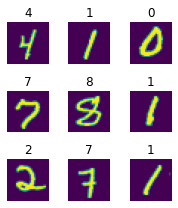

In [ ]:
# Kiểm tra dữ liệu:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, batch_size=32) # lấy toàn bộ dữ liệu theo batch
plt.figure(figsize=(3, 3))
# Nếu sử dụng batch_size trong hàm load:
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images['image'][i])
        plt.title(images['label'][i].numpy())
        plt.axis("off")
        plt.tight_layout()

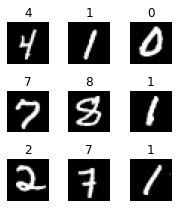

In [ ]:
# # Chuyển dữ liệu thành ảnh 3 channel:
# Nếu sử dụng batch_size trong hàm load:
plt.figure(figsize=(3, 3))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.repeat(images['image'][i], 3, -1))
        plt.title(images['label'][i].numpy())
        plt.axis('off')
        plt.tight_layout()

#### Tạo neural net cơ bản:

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28, 1), name='flatten'))
model.add(keras.layers.Dense(128, activation='relu', name='layer1'))
model.add(keras.layers.Dropout(0.5, name='dropout'))
model.add(keras.layers.Dense(20, activation='relu', name='layer2'))
model.add(keras.layers.Dense(10, activation='softmax', name='prediction'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
prediction (Dense)           (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create optimizer and loss_fuction
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
loss_func = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_func, metrics='accuracy')

In [ ]:
normalizer = keras.layers.experimental.preprocessing.Normalization(mean=0.485, variance=0.229**2, name='normalize')
for _, images in train_ds.take(1).enumerate():
    # divide to 255:
    images['image'] = tf.cast(images['image'], tf.float32)/255.
    images['image'] = normalizer(images['image'])
    model.fit(images['image'], images['label'])

1/1 [==============================] - 2s 2s/step - loss: 4.8416 - accuracy: 0.0938


__Lưu ý:__ với tensorflow dataset, chúng ta muốn biến đổi dữ liệu cần áp dụng mapping với dữ liệu này, sử dụng phương pháp: `tf.data.Dataset.map`

Ở đây, tương tự như bài toán của keras.dataset, chúng ta sẽ cần biến dữ liệu về khoảng 0-1 rồi normalize lại dữ liệu:

In [ ]:
def divide_pixel(tensor):
    tensor['image'] = tf.cast(tensor['image'], tf.float32)/255.
    return tensor

def normalize_image(tensor):
    normalizer = keras.layers.experimental.preprocessing.Normalization(mean=.485, variance=.229**2, name='imagenet_stats')
    tensor['image'] = normalizer(tensor['image'])
    return tensor

train_ds = train_ds.map(divide_pixel)
train_ds = train_ds.map(normalize_image)

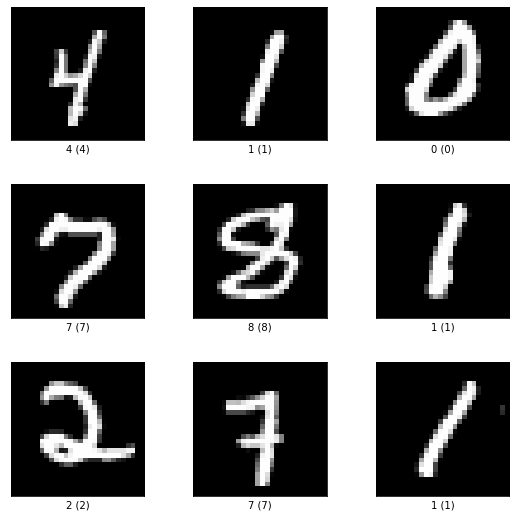

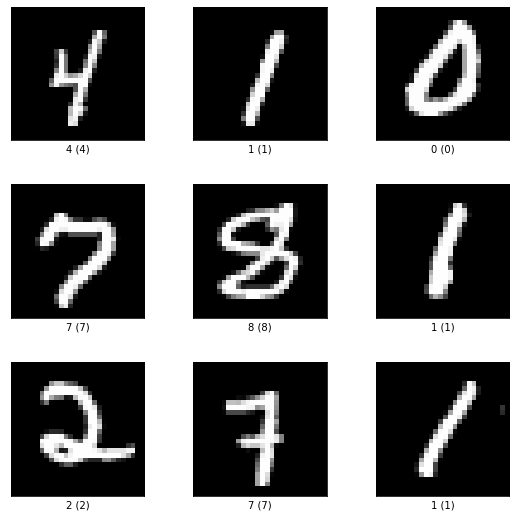

In [ ]:
# Cách khác để có thể xem được hình ảnh:
train_ds, info = tfds.load('mnist', split='train', shuffle_files=True, with_info=True)
tfds.show_examples(train_ds, info)

In [ ]:
# Tạo một model đơn giản:
model_tf = keras.Sequential([
    keras.layers.Flatten(name='flatten', input_shape=(28, 28, 1)),
    keras.layers.Dense(250, activation='relu', name='layer1'), 
    keras.layers.Dropout(.5, name='dropout'),
    keras.layers.Dense(10, activation='softmax', name='layer2')
])
model.compile(optimizer='rmsprop', loss='caterogical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
prediction (Dense)           (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________
